In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# Read data from csv files
stock_df = pd.read_csv('../Data/loreal_stock_price.csv', parse_dates=['Date'])
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv', parse_dates=['Date'])
indices_df = pd.read_csv('../Data/expanded_df_id_interpolated.csv', parse_dates=['Date'])


# Result breakdown

**Mean Squared Error:** The relatively low MSE(about 29.1) compared to the range of mean close prices from 238.9 to 415.8 indicates that the model's predictions are quite close to the actual values.

**R-squared score:** R-squared approximately 0.94 reveals that about 94% of the variance in the stock prices is explained by the model. It can be said that this model has a strong predictive capability with high reliability.

**Formula:** The model has calculated the general formula for predicting the stock price based 

In [ ]:
# Preprocessing data

# Convert to datetime and consider the date part
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc = True).dt.date
currency_df['Date'] = pd.to_datetime(currency_df['Date'], utc = True).dt.date
indices_df['Date'] = pd.to_datetime(indices_df['Date'], utc = True).dt.date

# Consider only the relevant columns
stock_df = stock_df[['Date', 'Close']]
stock_df.columns = ['Date', 'Close Stock Price']
currency_df = currency_df[['Date', 'Close']]
currency_df.columns = ['Date', 'Close Currency Rate']
indices_df = indices_df[['Date', 'Total_Sales_EUR_Million', 'EPS']]

# Merge the dataframes on 'Date' column
merged_df = pd.merge(stock_df, currency_df, on = 'Date', how = 'outer')
merged_df = pd.merge(merged_df, indices_df, on = 'Date', how = 'outer')

# Handle missing values
cutoff_date = pd.to_datetime('2019-11-11').date()
merged_df = merged_df[merged_df['Date'] >= cutoff_date]
merged_df.interpolate(method='linear', inplace=True)
#merged_df.to_csv('merged_data.csv', index=False)

C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\4051676148.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method='linear', inplace=True)


[ 1.00713272e+00 -2.79564454e-02  6.13869283e-03  4.30059133e-02
 -9.23960773e-02  7.80373585e-02 -1.41469213e-02 -2.83085624e-02
  3.13841904e-02 -3.47510085e-02  3.82344596e-02 -2.34687373e-02
  3.80471537e-02 -4.91404735e-02  7.57812275e-03  4.51782430e-02
 -4.13221357e-02  2.26882015e-02 -4.66712066e-02  8.00479621e-02
 -7.09955811e-02  1.76673777e-02  3.29978196e-02 -4.11120440e-02
  6.17920986e-02 -4.06289057e-02  3.28132305e-02 -6.66893407e-02
  5.25846750e-02 -2.68987038e-02  4.02568050e+01 -2.63664724e+01
 -3.35004017e+01 -6.15768629e+00  3.13423415e+01 -6.76832654e+00
 -1.93240689e+01  6.59052588e+01 -6.36631544e+01  4.05057270e+01
  1.61011989e+01 -5.85286232e+01  1.11729081e+01 -9.74125069e+00
  4.50703431e+01 -2.48591139e+01 -6.11073100e+00  2.59089045e+01
 -3.25509970e+01  3.02315388e+01 -3.19495853e+01  3.32087830e+01
 -5.56979259e+01 -1.51607410e+00  4.29150902e+01 -4.77206330e+00
  8.14162115e-01 -2.97523810e+01  7.40960717e+01 -4.32765199e+01
 -4.51273718e-02  1.74739

C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3234955898.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3234955898.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3234955898.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

            Predicted Stock Price
2024-11-11           3.258622e+05
2024-11-12           6.536988e+05
2024-11-13           9.838738e+05
2024-11-14           1.316404e+06
2024-11-15           1.651306e+06
2024-11-18           1.988596e+06
2024-11-19           2.328293e+06
2024-11-20           2.670412e+06
2024-11-21           3.014972e+06
2024-11-22           3.361989e+06
2024-11-25           3.711482e+06
2024-11-26           4.063467e+06
2024-11-27           4.417963e+06
2024-11-28           4.774987e+06
2024-11-29           5.134558e+06
2024-12-02           5.496694e+06
2024-12-03           5.861413e+06
2024-12-04           6.228733e+06
2024-12-05           6.598673e+06
2024-12-06           6.971252e+06
2024-12-09           7.346488e+06
2024-12-10           7.724401e+06
2024-12-11           8.105010e+06
2024-12-12           8.488333e+06
2024-12-13           8.874390e+06
2024-12-16           9.263201e+06
2024-12-17           9.654785e+06
2024-12-18           1.004916e+07
2024-12-19    

C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWa

ValueError: x and y must have same first dimension, but have shapes (30,) and (1760,)

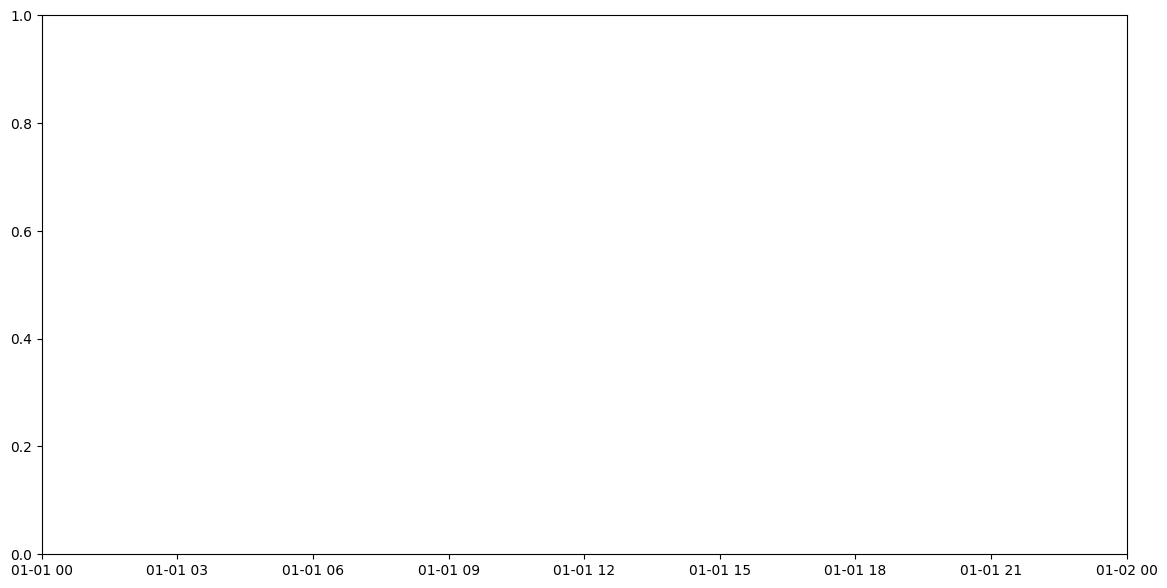

In [17]:
# Linear regression model

# Read csv file
merged_df = pd.read_csv('../Data/merged_data.csv')

# Create 30-day lag features(stockprice, currencyrate, indices)
lag_features = {}
for lag in range (1, 31):
    lag_features[f'Stock_Lag{lag}'] = merged_df['Close Stock Price'].shift(lag)
    lag_features[f'Currency_Lag{lag}'] = merged_df['Close Currency Rate'].shift(lag)
    lag_features[f'Sales_Lag{lag}'] = merged_df['Total_Sales_EUR_Million'].shift(lag)
    lag_features[f'EPS_Lag{lag}'] = merged_df['EPS'].shift(lag)
lag_df = pd.DataFrame(lag_features)
merged_df = pd.concat([merged_df, lag_df], axis=1)

# Drop records having null value from lagged-dataframe
merged_df.dropna(inplace=True)

# Define features and target
features = [f'Stock_Lag{lag}' for lag in range(1,31)] + \
           [f'Currency_Lag{lag}' for lag in range(1,31)] + \
           [f'Sales_Lag{lag}' for lag in range(1,31)] + \
           [f'EPS_Lag{lag}' for lag in range(1,31)]
target = 'Close Stock Price'

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)

# Model prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-Squared Error: ", mse)
print("R-squared Score: ", r2)

# Predict the stock price for the next 30 days
last_row = merged_df.iloc[-1]
future_dates = pd.date_range(start=last_row['Date'], periods=30, freq='B')
future_data = pd.DataFrame(index=future_dates)

# Initialize future data with the last known values
for lag in range(1, 31):
    future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
    future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
    future_data[f'Sales_Lag{lag}'] = last_row[f'Sales_Lag{lag}']
    future_data[f'EPS_Lag{lag}'] = last_row[f'EPS_Lag{lag}']

# Predict future stock prices iteratively
future_predictions = []
for i in range(len(future_data)):
    prediction = model.predict(future_data.iloc[i].values.reshape(1, -1))
    future_predictions.append(prediction[0])
    if i + 1 < len(future_data):
        future_data.iloc[i + 1, :30] = future_data.iloc[i, :30].values
        future_data.iloc[i + 1, 30:60] = future_data.iloc[i, 30:60].values 
        future_data.iloc[i + 1, 60:90] = future_data.iloc[i, 60:90].values
        future_data.iloc[i + 1, 90:] = future_data.iloc[i, 90:].values
        future_data.iloc[i + 1, 0] = prediction[0]
# Add predictions to future data
future_data['Predicted Stock Price'] = future_predictions

# Print future predictions
print(future_data[['Predicted Stock Price']])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(future_data.index, merged_df['Close Stock Price'], label='Actual Stock Price') 
plt.plot(future_data.index, future_data['Predicted Stock Price'], label='Predicted Stock Price', linestyle='--') 
plt.xlabel('Date') 
plt.ylabel('Stock Price') 
plt.title('Stock Price Prediction for the Next 30 Days') 
plt.legend() 
plt.grid(True) 
plt.show()


print(merged_df)

The formula to predict the stock price is: -4.0586 + 1.0071*Stock_Lag1 + -0.0280*Stock_Lag2 + 0.0061*Stock_Lag3 + 0.0430*Stock_Lag4 + -0.0924*Stock_Lag5 + 0.0780*Stock_Lag6 + -0.0141*Stock_Lag7 + -0.0283*Stock_Lag8 + 0.0314*Stock_Lag9 + -0.0348*Stock_Lag10 + 0.0382*Stock_Lag11 + -0.0235*Stock_Lag12 + 0.0380*Stock_Lag13 + -0.0491*Stock_Lag14 + 0.0076*Stock_Lag15 + 0.0452*Stock_Lag16 + -0.0413*Stock_Lag17 + 0.0227*Stock_Lag18 + -0.0467*Stock_Lag19 + 0.0800*Stock_Lag20 + -0.0710*Stock_Lag21 + 0.0177*Stock_Lag22 + 0.0330*Stock_Lag23 + -0.0411*Stock_Lag24 + 0.0618*Stock_Lag25 + -0.0406*Stock_Lag26 + 0.0328*Stock_Lag27 + -0.0667*Stock_Lag28 + 0.0526*Stock_Lag29 + -0.0269*Stock_Lag30 + 40.2568*Currency_Lag1 + -26.3665*Currency_Lag2 + -33.5004*Currency_Lag3 + -6.1577*Currency_Lag4 + 31.3423*Currency_Lag5 + -6.7683*Currency_Lag6 + -19.3241*Currency_Lag7 + 65.9053*Currency_Lag8 + -63.6632*Currency_Lag9 + 40.5057*Currency_Lag10 + 16.1012*Currency_Lag11 + -58.5286*Currency_Lag12 + 11.1729*Currency

C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3353354201.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3353354201.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
C:\Users\abcam\AppData\Local\Temp\ipykernel_19356\3353354201.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

            Predicted Stock Price
2024-11-11           3.258622e+05
2024-11-12           6.545290e+05
2024-11-13           9.540063e+05
2024-11-14           1.233532e+06
2024-11-15           1.513428e+06
2024-11-18           1.780641e+06
2024-11-19           2.006314e+06
2024-11-20           2.208007e+06
2024-11-21           2.409324e+06
2024-11-22          -8.290415e+06
2024-11-25          -3.636602e+07
2024-11-26          -7.477895e+07
2024-11-27          -1.063838e+08
2024-11-28          -1.416875e+08
2024-11-29          -2.013373e+08
2024-12-02          -2.820684e+08
2024-12-03          -3.769704e+08
2024-12-04          -4.860155e+08
2024-12-05          -2.480768e+08
2024-12-06           1.134237e+09
2024-12-09           4.148370e+09
2024-12-10           7.912838e+09
2024-12-11           1.172793e+10
2024-12-12           1.730760e+10
2024-12-13           2.736018e+10
2024-12-16           4.231418e+10
2024-12-17           6.086380e+10
2024-12-18           7.143691e+10
2024-12-19    

C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\abcam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWa

ValueError: x and y must have same first dimension, but have shapes (30,) and (1760,)

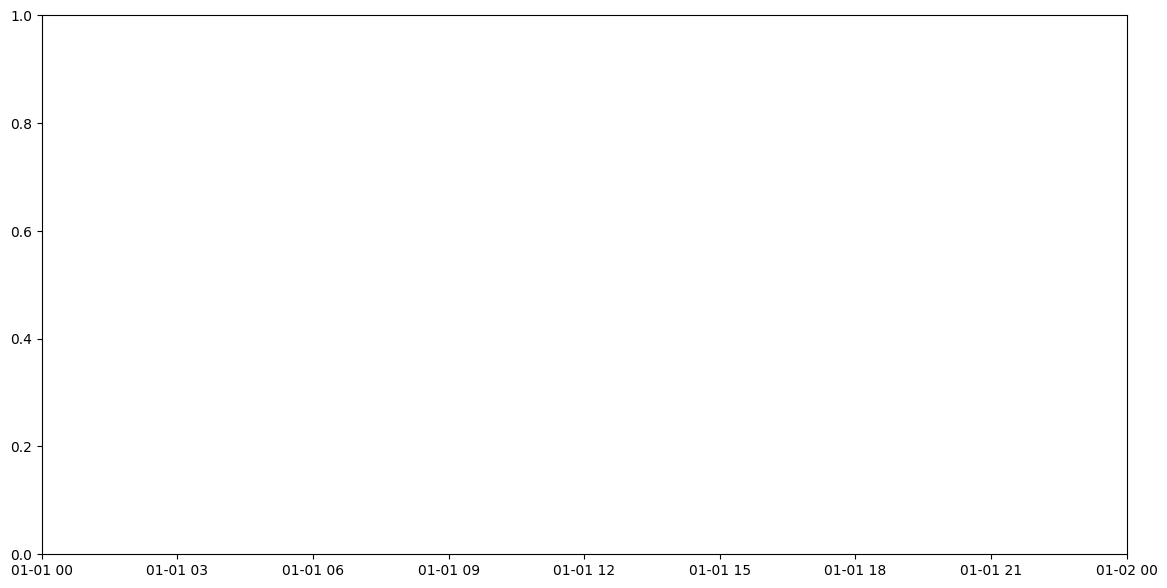

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the merged data
merged_df = pd.read_csv('../Data/merged_data.csv')

# Convert the Date column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Feature engineering: Create lag features for the past 30 days
lag_features = {}
for lag in range(1, 31):
    lag_features[f'Stock_Lag{lag}'] = merged_df['Close Stock Price'].shift(lag)
    lag_features[f'Currency_Lag{lag}'] = merged_df['Close Currency Rate'].shift(lag)
    lag_features[f'Sales_Lag{lag}'] = merged_df['Total_Sales_EUR_Million'].shift(lag)
    lag_features[f'EPS_Lag{lag}'] = merged_df['EPS'].shift(lag)

# Concatenate the lag features with the original DataFrame
lag_df = pd.DataFrame(lag_features)
merged_df = pd.concat([merged_df, lag_df], axis=1)

# Drop rows with NaN values resulting from lag features
merged_df.dropna(inplace=True)

# Define features and target
features = [f'Stock_Lag{lag}' for lag in range(1, 31)] + \
           [f'Currency_Lag{lag}' for lag in range(1, 31)] + \
           [f'Sales_Lag{lag}' for lag in range(1, 31)] + \
           [f'EPS_Lag{lag}' for lag in range(1, 31)]
target = 'Close Stock Price'

X = merged_df[features]
y = merged_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Formula checking
# Print the coefficients and intercept
intercept = model.intercept_
coefficients = model.coef_

# Construct the formula 
formula_parts = [f"{intercept:.4f}"]
for i in range(1, 31):
    formula_parts.append(f"{coefficients[i-1]:.4f}*Stock_Lag{i}")
for i in range(1, 31):
    formula_parts.append(f"{coefficients[30+i-1]:.4f}*Currency_Lag{i}")
for i in range(1, 31):
    formula_parts.append(f"{coefficients[60+i-1]:.4f}*Sales_Lag{i}")
for i in range(1, 31):
    formula_parts.append(f"{coefficients[90+i-1]:.4f}*EPS_Lag{i}")

formula = " + ".join(formula_parts)

print(f"The formula to predict the stock price is: {formula}")

# Model prediction
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean-Squared Error: ", mse)
print("R-squared Score: ", r2)

# Predict the stock price for the next 30 days
last_row = merged_df.iloc[-1]
future_dates = pd.date_range(start=last_row['Date'], periods=30, freq='B')
future_data = pd.DataFrame(index=future_dates)

# Initialize future data with the last known values
for lag in range(1, 31):
    future_data[f'Stock_Lag{lag}'] = last_row[f'Stock_Lag{lag}']
    future_data[f'Currency_Lag{lag}'] = last_row[f'Currency_Lag{lag}']
    future_data[f'Sales_Lag{lag}'] = last_row[f'Sales_Lag{lag}']
    future_data[f'EPS_Lag{lag}'] = last_row[f'EPS_Lag{lag}']

# Predict future stock prices iteratively
future_predictions = []
for i in range(len(future_data)):
    prediction = model.predict(future_data.iloc[i].values.reshape(1, -1))
    future_predictions.append(prediction[0])
    if i + 1 < len(future_data):
        # Update the lag features for the next day
        for lag in range(30, 1, -1):
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Stock_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Stock_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Currency_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Currency_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'Sales_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'Sales_Lag{lag-1}')]
            future_data.iloc[i + 1, future_data.columns.get_loc(f'EPS_Lag{lag}')] = future_data.iloc[i, future_data.columns.get_loc(f'EPS_Lag{lag-1}')]

        # Update the stock price lag with the predicted value
        future_data.iloc[i + 1, future_data.columns.get_loc('Stock_Lag1')] = prediction[0]

# Add predictions to future_data
future_data['Predicted Stock Price'] = future_predictions

# Print future predictions
print(future_data[['Predicted Stock Price']])

# Plot the results with adjusted y-axis limits to reflect actual stock prices
plt.figure(figsize=(14, 7))
plt.plot(future_data.index, merged_df['Close Stock Price'], label='Actual Stock Price')
plt.plot(future_data.index, future_data['Predicted Stock Price'], label='Predicted Stock Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for the Next 30 Days')
plt.legend()
plt.grid(True)
plt.ylim([merged_df['Close Stock Price'].min() - 10, merged_df['Close Stock Price'].max() + 10]) # Adjust y-axis limits
plt.show()

# Print the merged DataFrame to check the Date column and Close Stock Price column
print(merged_df[['Date', 'Close Stock Price']])


In [ ]:
import pandas as pd
import numpy as np

# Provided dataset
data = [
    ["2020-04-01", 219.162415, 1.095362, 5851.300000, 3.820000],
    ["2020-04-02", 217.596954, 1.084740, 5864.327473, 3.816264],
    ["2020-04-03", 217.320699, 1.083392, 5877.354945, 3.812527],
    ["2020-04-04", 217.044444, 1.082044, 5890.382418, 3.808791],
    ["2020-04-05", 216.768188, 1.080696, 5903.409890, 3.805055],
    ["2020-04-06", 221.004105, 1.080380, 5916.437363, 3.801319],
    ["2020-04-07", 223.214157, 1.089514, 5929.464835, 3.797582],
    ["2020-04-08", 225.424194, 1.086366, 5942.492308, 3.793846],
    ["2020-04-09", 226.473965, 1.092741, 5955.519780, 3.790110],
    ["2020-04-10", 227.523737, 1.092916, 5968.547253, 3.786374],
    ["2020-04-11", 228.573508, 1.093091, 5981.574725, 3.782637],
    ["2020-04-12", 229.623279, 1.093267, 5994.602198, 3.778901],
    ["2020-04-13", 230.673050, 1.092299, 6007.629670, 3.775165],
    ["2020-04-14", 226.437119, 1.098539, 6020.657143, 3.771429],
    ["2020-04-15", 225.147934, 1.090510, 6033.684615, 3.767692],
    ["2020-04-16", 228.002594, 1.085847, 6046.712088, 3.763956],
    ["2020-04-17", 230.488887, 1.086130, 6059.739560, 3.760220],
    ["2020-04-18", 232.975179, 1.086413, 6072.767033, 3.756484],
    ["2020-04-19", 235.461472, 1.086697, 6085.794505, 3.752747],
    ["2020-04-20", 226.345047, 1.086484, 6098.821978, 3.749011],
    ["2020-04-21", 228.462997, 1.085647, 6111.849451, 3.745275],
    ["2020-04-22", 226.345047, 1.080964, 6124.876923, 3.741538],
    ["2020-04-23", 224.042908, 1.077702, 6137.904396, 3.737802],
    ["2020-04-24", 224.933065, 1.079258, 6150.931868, 3.734066],
    ["2020-04-25", 225.823222, 1.080813, 6163.959341, 3.730330],
    ["2020-04-26", 226.713379, 1.082368, 6176.986813, 3.726593],
    ["2020-04-27", 234.264359, 1.082485, 6190.014286, 3.722857],
    ["2020-04-28", 235.921890, 1.083658, 6203.041758, 3.719121],
    ["2020-04-29", 244.301620, 1.087725, 6216.069231, 3.715385],
    ["2020-04-30", 240.825409, 1.094547, 6229.096703, 3.711648],
    ["2020-05-01", 237.349197, 1.095019, 6242.124176, 3.707912]
]

# Convert the data to a DataFrame
columns = ['Date', 'Stock Price', 'Currency Exchange Rate', 'Total Sales', 'EPS']
df = pd.DataFrame(data, columns=columns)

# Create lagged features for the past days
lag_features = {}
for lag in range(1, 31):
    lag_features[f'Stock_Lag{lag}'] = df['Stock Price'].shift(lag)
    lag_features[f'Currency_Lag{lag}'] = df['Currency Exchange Rate'].shift(lag)
    lag_features[f'Sales_Lag{lag}'] = df['Total Sales'].shift(lag)
    lag_features[f'EPS_Lag{lag}'] = df['EPS'].shift(lag)

# Concatenate the lag features with the original DataFrame
lag_df = pd.DataFrame(lag_features)
df = pd.concat([df, lag_df], axis=1).dropna()

# Define the features for the last row (31st day)
features = [f'Stock_Lag{lag}' for lag in range(1, 31)] + \
           [f'Currency_Lag{lag}' for lag in range(1, 31)] + \
           [f'Sales_Lag{lag}' for lag in range(1, 31)] + \
           [f'EPS_Lag{lag}' for lag in range(1, 31)]

# Extract the feature values for the last row
X_last_row = df[features].iloc[-1].values

# Define the coefficients from the formula
coefficients = np.array([
    -4.0586, 1.0071, -0.0280, 0.0061, 0.0430, -0.0924, 0.0780, -0.0141, -0.0283, 0.0314, -0.0348, 0.0382, -0.0235, 0.0380, -0.0491, 0.0076, 0.0452, -0.0413, 0.0227, -0.0467, 0.0800, -0.0710, 0.0177, 0.0330, -0.0411, 0.0618, -0.0406, 0.0328, -0.0667, 0.0526, -0.0269,
    40.2568, -26.3665, -33.5004, -6.1577, 31.3423, -6.7683, -19.3241, 65.9053, -63.6632, 40.5057, 16.1012, -58.5286, 11.1729, -9.7413, 45.0703, -24.8591, -6.1107, 25.9089, -32.5510, 30.2315, -31.9496, 33.2088, -55.6979, -1.5161, 42.9151, -4.7721, 0.8142, -29.7524, 74.0961, -43.2765,
    -0.0451, 0.1747, -0.2256, 0.1325, -0.0915, 0.0842, 0.1079, -0.3197, 0.2326, -0.0741, 0.0354, -0.0206, -0.0520, 0.1831, -0.1406, 0.0653, -0.0822, 0.0343, -0.0190, 0.0149, -0.0979, 0.1101, -0.0615, 0.2980, -0.1091, -0.2904, 0.2882, -0.1178, -0.2490, 0.2351,
    -57.5074, 130.2966, -95.4387, 45.0645, -140.6807, 234.9221, -18.7958, -214.4149, -214.4149, 129.1726, 61.5311, 76.4582, -374.7514, 223.6111, -65.6112, 198.9440, -194.2118, -123.3995, 245.4226, 256.5501, -442.7221, 152.1046, -131.4378, -39.2740, 304.0404, -122.0923, -35.2614, -79.5406, 162.0266, -136.5800, 51.2797
])
# Calculate the predicted stock price for the last row (31st day)
predicted_stock_price = np.dot(coefficients[1:], X_last_row) + coefficients[0]

print(f"The predicted stock price on 2020-05-01 is {predicted_stock_price}")

ValueError: shapes (121,) and (120,) not aligned: 121 (dim 0) != 120 (dim 0)

[4.14394935e+02 3.81162157e-02 1.18634788e+01]
-528.8996030084332


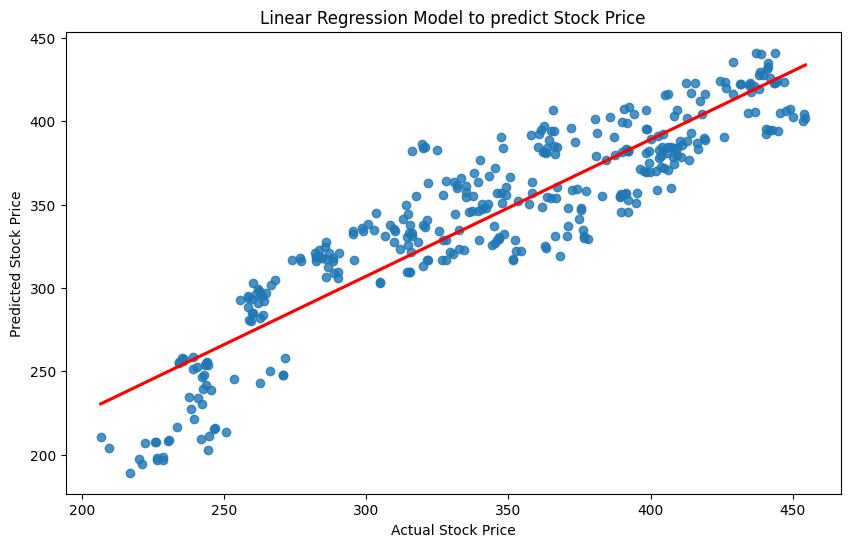

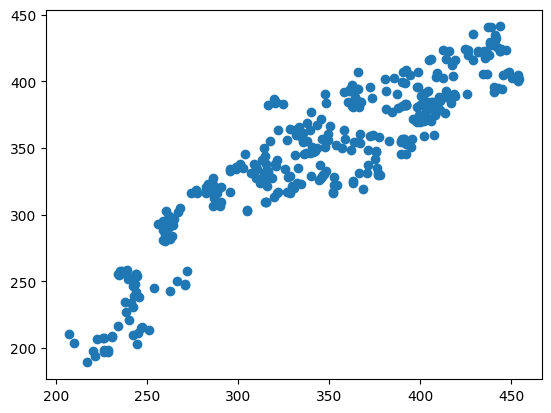

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load dataset from cav files
data_df = pd.read_csv('../Data/merged_data.csv')
X = data_df[['Close Currency Rate', 'Total_Sales_EUR_Million', 'EPS']]
y = data_df['Close Stock Price']
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)
pd.DataFrame(model.coef_, X.columns, columns = ['Coef'])
y_pred = model.predict(X_test)

#  Plot
plt.figure(figsize=(10,6))
sns.regplot(x=y_test, y=y_pred, ci=None, line_kws={"color": "red"})
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.title('Linear Regression Model to predict Stock Price')
plt.show()
plt.scatter(y_test, y_pred)



In [25]:
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)
metrics.mean_squared_error(y_test, y_pred)


np.float64(758.5408272946241)

ValueError: x and y must be the same size

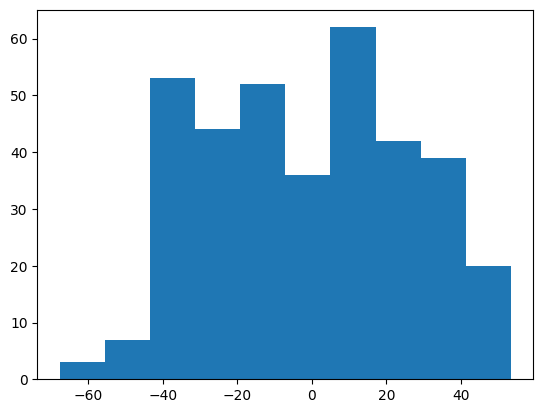

In [ ]:
# Plot
plt.hist(y_test - y_pred)
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)
metrics.mean_squared_error(y_test, y_pred)
metrics.r2_score(y_test, y_pred)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))
plt.scatter(X_test, y_test)
plt.
plt.plot(X, model)
plt.show()